# BurnMan - Step 1 -  Compute seismic velocities

Copyright (C) 2012 - 2018 by the BurnMan team, released under the GNU GPL v2 or later.
Released under GPL v2 or later.

This example script is intended for absolute beginners to BurnMan.
We cover importing BurnMan modules, creating a composite material,
and calculating its seismic properties at lower mantle pressures and
temperatures.  Afterwards, we plot it against a 1D seismic model
for visual comparison. Run the seperate cells of the code with shift+enter

requires:

- geotherms

- seismic models

- compute seismic velocities

- composite mineral helpers

teaches:

- changing composition
- changing geotherm
- computing self-consistent depth to compare to seismology

### 1. Import modules

Here we import standard python modules that are required for 
usage of BurnMan.  In particular, numpy is used for handling
numerical arrays and mathematical operations on them, and 
matplotlib is used for generating plots of results of calculations

In [2]:
%matplotlib inline 
import os, sys, numpy as np, matplotlib.pyplot as plt
sys.path.insert(1,os.path.abspath('./BurnMan_developersversion/'))

['', '/Users/sanne/Documents/Research/Side_projects/Cider2018/Practical_burnman/BurnMan_developersversion', '/Users/sanne/Documents/Research/Side_projects/Cider2018/Practical_burnman/BurnMan_developersversion', '/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python36.zip', '/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6', '/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/lib-dynload', '/usr/local/lib/python3.6/site-packages', '/usr/local/lib/python3.6/site-packages/IPython/extensions', '/Users/sanne/.ipython']


Here we import the relevant modules from BurnMan.  The burnman
module imports several of the most important functionalities of
the library, including the ability to make composites, and compute
thermoelastic properties of them.  The minerals module includes
the mineral physical parameters for the predefined minerals in
BurnMan

In [3]:
import burnman
print(burnman.__path__)
from burnman import minerals

['/Users/sanne/Documents/Research/Side_projects/Cider2018/Practical_burnman/BurnMan_developersversion/burnman']


### 2. Import seismic model

Here we create and load the PREM seismic velocity model, which will be
used for comparison with the seismic velocities of the "rock" composite

In [4]:
seismic_model = burnman.seismic.PREM()

We create an array of 20 depths at which we want to evaluate PREM, and then
query the seismic model for the pressure, density, P wave speed, S wave
speed, and bulk sound velocity at those depths

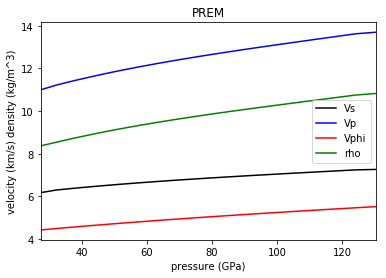

In [5]:
depths = np.linspace(750e3, 2800e3, 20)
pressure, seis_rho, seis_vp, seis_vs, seis_vphi = \
                        seismic_model.evaluate(['pressure','density','v_p','v_s','v_phi'],depths)

plt.plot(pressure/1.e9,seis_vs/1.e3,'k',label='Vs')
plt.plot(pressure/1.e9,seis_vp/1.e3,'b',label='Vp')
plt.plot(pressure/1.e9,seis_rho/1.e3,'r',label='Vphi')
plt.plot(pressure/1.e9,seis_vphi/1.e3,'g',label='rho')
plt.xlabel('pressure (GPa)')
plt.ylabel('velocity (km/s) density (kg/m^3)')
plt.xlim(min(pressure)/1.e9,max(pressure)/1.e9)
plt.title('PREM')
plt.legend();

### 3. Input composition

We define
composite object and name it "rock".  A composite is made by
giving burnman.composite a list of minerals and their molar fractions.
Here "rock" has two constituent minerals: it is 80% Mg perovskite
and 20% periclase.  More minerals may be added by simply extending
the list given to burnman.composite

In [6]:
rock = burnman.Composite([minerals.SLB_2011.mg_perovskite(), minerals.SLB_2011.periclase()], \
                         [0.8, 0.2])

At this point we could tell the rock which equation of state to use for
its thermoelastic calculations. Methods available are:

- bm2 -- third order method with second order shear modulus (Stixrude & Lithgow-Berteloni 2005)- no temperature effects
- bm3 -- third order method (Stixrude & Lithgow-Berteloni 2005) - no temperature effects
- slb2 -- third order mehtod with second order shear modulus (Stixrude & Lithgow-Berteloni 2005)
- slb3 -- third order method (Stixrude & Lithgow-Berteloni 2005)
- mgd2 -- second order method (Matas et al. 2007) non-benchmarked
- mgd3 -- third order method (Matas et al. 2007) non-benchmarked

The SLB_2011 libarary has been established using 'slb3', this is the default method, and the only method that produces self-conssitent results. 

In [7]:
rock.set_method('slb3')

### 4. Input temperature

Now we get an array of temperatures at which will be used for computing
the seismic properties of the rock.  Here we use the Brown+Shankland (1981)
geotherm for mapping pressure to temperature

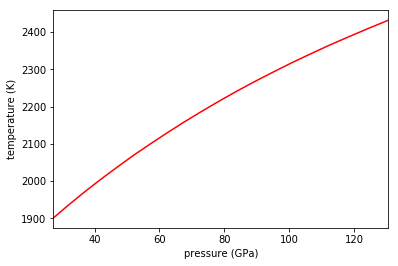

In [8]:
temperature = burnman.geotherm.brown_shankland(depths)
plt.plot(pressure/1.e9,temperature,'r')
plt.xlim(min(pressure)/1.e9,max(pressure)/1.e9)
plt.xlabel('pressure (GPa)')
plt.ylabel('temperature (K)');

### 4. Calculate velocities

    
Here is the step which does the heavy lifting.  burnman.velocities_from_rock sets the state of the rock at each of the pressures and temperatures defined,then calculates the elastic moduli and density of each individual phase.  After that,it performs elastic averaging on the phases to get a single bulk and shear
modulus for the rock.  This averaging scheme defaults to Voigt-Reuss-Hill,
but see example_averaging.py for other options.  Finally, it calculates the seismic
wave speeds for the whole rock.  It returns a tuple of density, p-wave velocity
s-wave velocity, bulk sound speed, bulk modulus, and shear modulus.

In [9]:
density, vp, vs, vphi, K, G = rock.evaluate(['density','v_p','v_s','v_phi','K_S','G'], pressure, temperature)

### 5. Plot results

All the work is done except the plotting!  Here we want to plot the seismic wave
speeds and the density against PREM using the matplotlib plotting tools.  

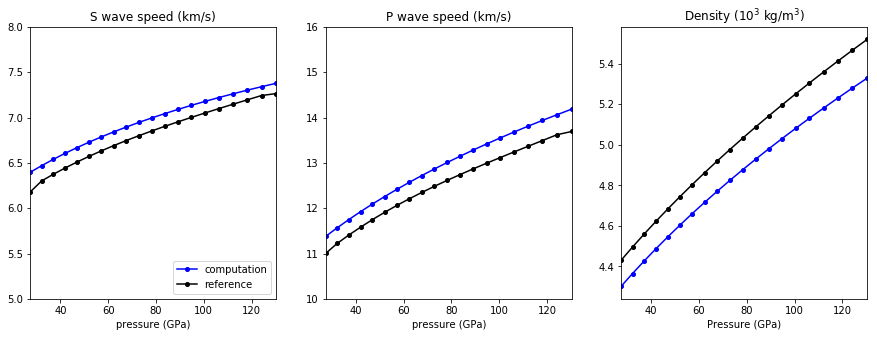

In [10]:
# First, we plot the s-wave speed verses the PREM s-wave speed
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(pressure/1.e9,vs/1.e3,color='b',linestyle='-',marker='o', markerfacecolor='b',markersize=4,label='computation')
plt.plot(pressure/1.e9,seis_vs/1.e3,color='k',linestyle='-',marker='o', markerfacecolor='k',markersize=4,label='reference')
plt.title("S wave speed (km/s)")
plt.xlim(min(pressure)/1.e9,max(pressure)/1.e9)
plt.xlabel('pressure (GPa)')
plt.legend(loc='lower right')
plt.ylim(5,8.0)
  

# Next, we plot the p-wave speed verses the PREM p-wave speed
plt.subplot(1,3,2)
plt.plot(pressure/1.e9,vp/1.e3,color='b',linestyle='-',marker='o',markerfacecolor='b',markersize=4)
plt.plot(pressure/1.e9,seis_vp/1.e3,color='k',linestyle='-',marker='o',markerfacecolor='k',markersize=4)
plt.title("P wave speed (km/s)")
plt.xlabel('pressure (GPa)')
plt.xlim(min(pressure)/1.e9,max(pressure)/1.e9)
plt.ylim(10,16)
    
# Next, we plot the density verses the PREM density
plt.subplot(1,3,3)
plt.plot(pressure/1.e9,density/1.e3,color='b',linestyle='-',marker='o', markerfacecolor='b',markersize=4)
plt.plot(pressure/1.e9,seis_rho/1.e3,color='k',linestyle='-',marker='o', markerfacecolor='k',markersize=4)
plt.xlim(min(pressure)/1.e9,max(pressure)/1.e9)
plt.xlabel("Pressure (GPa)")

plt.title("Density ($10^3$ kg/m$^3$)");